In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']="True"

In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.optim as optim
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

from MyDataset.ShipDataset import ShipDataset
from MyNetwork.Pix2Pix import Generator, Discriminator

In [3]:
# Root directory for dataset
dataroot = "../data/seg_ship_data/4-yyc_pic_output_train"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 16

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 256

# Number of channels in the training images. For color images this is 3
nic = 3

# Number of channels in the label images. For color images this is 1
noc = 1

# Number of training epochs
num_epochs = 50

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [4]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [5]:
def save_model(netG, netD, modelroot, epoch=num_epochs):
    path_g = os.path.join(modelroot, 'Generator_epoch_{0}.pkl'.format(epoch))
    path_d = os.path.join(modelroot, 'Discriminator_epoch_{0}.pkl'.format(epoch))
    torch.save(netG.state_dict(), path_g)
    torch.save(netD.state_dict(), path_d)

In [17]:
def train(netG, netD, dataloader, num_epochs, modelroot):

    # Initialize BCELoss function
    criterion = nn.BCELoss()

    # Establish convention for real and fake labels during training
    real_label = 1
    fake_label = 0

    # Setup Adam optimizers for both G and D
    optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
    optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

    # Training Loop

    # Lists to keep track of progress
    # img_list = []
    G_losses = []
    D_losses = []
    iters = 1

    print("Starting Training Loop...")
    # For each epoch
    for epoch in range(1, num_epochs+1):
        # For each batch in the dataloader
        for i, data in enumerate(dataloader, 0):

            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################
            ## Train with all-real batch
            netD.zero_grad()
            # Format batch
            batch_imgs = data[0].to(device)
            batch_labels = data[1].to(device)
            b_size = batch_imgs.size(0)
            label = torch.full((b_size,), real_label, device=device)
            # Forward pass real batch through D
            output = netD(batch_imgs, batch_labels).view(-1)
            # Calculate loss on all-real batch
            errD_real = criterion(output, label)
            # Calculate gradients for D in backward pass
            errD_real.backward()
            D_x = output.mean().item()

            ## Train with all-fake batch
            # Generate fake image batch with G
            fake = netG(batch_imgs)
            label.fill_(fake_label)
            # Classify all fake batch with D
            output = netD(batch_imgs, fake.detach()).view(-1)
            # Calculate D's loss on the all-fake batch
            errD_fake = criterion(output, label)
            # Calculate the gradients for this batch
            errD_fake.backward()
            D_G_z1 = output.mean().item()
            # Add the gradients from the all-real and all-fake batches
            errD = errD_real + errD_fake
            # Update D
            optimizerD.step()

            ############################
            # (2) Update G network: maximize log(D(G(z)))
            ###########################
            netG.zero_grad()
            label.fill_(real_label)  # fake labels are real for generator cost
            # Since we just updated D, perform another forward pass of all-fake batch through D
            output = netD(batch_imgs, fake).view(-1)
            # Calculate G's loss based on this output
            errG = criterion(output, label)
            # Calculate gradients for G
            errG.backward()
            D_G_z2 = output.mean().item()
            # Update G
            optimizerG.step()

            # Output training stats
            if i % 2 == 0:
                print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                      % (epoch, num_epochs, i, len(dataloader),
                         errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

            # Save Losses for plotting later
            G_losses.append(errG.item())
            D_losses.append(errD.item())

            iters += 1
            
        save_model(netG, netD, modelroot, epoch)
    return G_losses, D_losses

In [18]:
def test():
    pass

In [19]:
def show_losses(G_losses, D_losses):
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss During Training")
    plt.plot(G_losses,label="G")
    plt.plot(D_losses,label="D")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [20]:
dataset = ShipDataset(dataroot, transform_img=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
                           ]), transform_label=transforms.Compose([
                                transforms.Resize(image_size),
                                transforms.CenterCrop(image_size),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5,), std=(0.5,)),
                            ]))

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

In [21]:
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

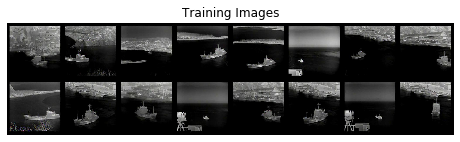

In [22]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:batch_size], padding=2, normalize=True).cpu(),(1,2,0)))

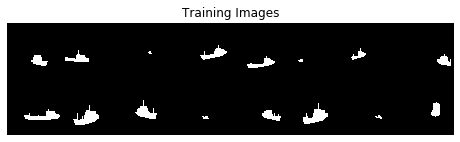

In [23]:
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[1].to(device)[:batch_size], padding=2, normalize=True).cpu(),(1,2,0)))

In [24]:
# Create the generator
netG = Generator(in_channels=nic, out_channels=noc).to(device)

In [25]:
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

Generator(
  (c0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (c1): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (c2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (c3): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (c4): Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (c5): Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (c6): Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (c7): Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (d7): ConvTranspose2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (d6): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (d5): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (d4): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (d3): ConvTranspose2d(1024, 256, kernel_

In [26]:
# Create the Discriminator
netD = Discriminator(in_channels1=nic, in_channels2=noc).to(device)

In [27]:
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

Discriminator(
  (c0): Conv2d(4, 64, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
  (c1): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
  (c2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
  (c3): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
  (c4): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
  (bnc1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bnc2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bnc3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [28]:
G_losses, D_losses = train(netG, netD, dataloader, num_epochs, '../model/')

Starting Training Loop...


/Users/app/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/Users/app/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


[1/50][0/32]	Loss_D: 1.8482	Loss_G: 0.5433	D(x): 0.8042	D(G(z)): 0.8024 / 0.5821
[1/50][2/32]	Loss_D: 1.2747	Loss_G: 0.9183	D(x): 0.5957	D(G(z)): 0.5239 / 0.4039
[1/50][4/32]	Loss_D: 0.9917	Loss_G: 1.0991	D(x): 0.6054	D(G(z)): 0.3839 / 0.3359
[1/50][6/32]	Loss_D: 0.8223	Loss_G: 1.2058	D(x): 0.6412	D(G(z)): 0.3098 / 0.2998
[1/50][8/32]	Loss_D: 0.5718	Loss_G: 1.7722	D(x): 0.7614	D(G(z)): 0.2578 / 0.1714
[1/50][10/32]	Loss_D: 0.4149	Loss_G: 2.0524	D(x): 0.8316	D(G(z)): 0.2051 / 0.1314
[1/50][12/32]	Loss_D: 0.2826	Loss_G: 2.3911	D(x): 0.8715	D(G(z)): 0.1349 / 0.0927
[1/50][14/32]	Loss_D: 0.2257	Loss_G: 2.5595	D(x): 0.8971	D(G(z)): 0.1098 / 0.0788
[1/50][16/32]	Loss_D: 0.2122	Loss_G: 2.5571	D(x): 0.9042	D(G(z)): 0.1027 / 0.0792
[1/50][18/32]	Loss_D: 0.1836	Loss_G: 2.9067	D(x): 0.9133	D(G(z)): 0.0876 / 0.0581
[1/50][20/32]	Loss_D: 0.2101	Loss_G: 3.1737	D(x): 0.9328	D(G(z)): 0.1298 / 0.0423
[1/50][22/32]	Loss_D: 0.1450	Loss_G: 3.2931	D(x): 0.9371	D(G(z)): 0.0764 / 0.0394
[1/50][24/32]	Loss_D:

[7/50][10/32]	Loss_D: 1.3829	Loss_G: 0.7491	D(x): 0.5288	D(G(z)): 0.5256 / 0.4728
[7/50][12/32]	Loss_D: 1.3817	Loss_G: 0.6798	D(x): 0.5111	D(G(z)): 0.5086 / 0.5067
[7/50][14/32]	Loss_D: 1.3799	Loss_G: 0.6873	D(x): 0.4954	D(G(z)): 0.4920 / 0.5029
[7/50][16/32]	Loss_D: 1.3810	Loss_G: 0.7212	D(x): 0.5111	D(G(z)): 0.5082 / 0.4862
[7/50][18/32]	Loss_D: 1.3824	Loss_G: 0.7360	D(x): 0.5292	D(G(z)): 0.5257 / 0.4791
[7/50][20/32]	Loss_D: 1.3790	Loss_G: 0.6840	D(x): 0.5094	D(G(z)): 0.5056 / 0.5046
[7/50][22/32]	Loss_D: 1.3834	Loss_G: 0.6593	D(x): 0.4809	D(G(z)): 0.4786 / 0.5172
[7/50][24/32]	Loss_D: 1.3818	Loss_G: 0.6476	D(x): 0.4778	D(G(z)): 0.4744 / 0.5233
[7/50][26/32]	Loss_D: 1.3841	Loss_G: 0.6465	D(x): 0.4727	D(G(z)): 0.4700 / 0.5239
[7/50][28/32]	Loss_D: 1.3849	Loss_G: 0.6218	D(x): 0.4654	D(G(z)): 0.4621 / 0.5370
[7/50][30/32]	Loss_D: 1.3879	Loss_G: 0.6212	D(x): 0.4572	D(G(z)): 0.4540 / 0.5373
[8/50][0/32]	Loss_D: 1.3956	Loss_G: 0.6011	D(x): 0.4426	D(G(z)): 0.4404 / 0.5482
[8/50][2/32]	Loss

[13/50][18/32]	Loss_D: 1.3848	Loss_G: 0.6593	D(x): 0.4897	D(G(z)): 0.4887 / 0.5172
[13/50][20/32]	Loss_D: 1.3872	Loss_G: 0.6443	D(x): 0.4756	D(G(z)): 0.4748 / 0.5250
[13/50][22/32]	Loss_D: 1.3887	Loss_G: 0.6425	D(x): 0.4680	D(G(z)): 0.4669 / 0.5260
[13/50][24/32]	Loss_D: 1.3877	Loss_G: 0.6542	D(x): 0.4717	D(G(z)): 0.4708 / 0.5199
[13/50][26/32]	Loss_D: 1.3858	Loss_G: 0.6755	D(x): 0.4827	D(G(z)): 0.4817 / 0.5090
[13/50][28/32]	Loss_D: 1.3850	Loss_G: 0.6812	D(x): 0.4900	D(G(z)): 0.4890 / 0.5060
[13/50][30/32]	Loss_D: 1.3846	Loss_G: 0.7000	D(x): 0.5031	D(G(z)): 0.5023 / 0.4966
[14/50][0/32]	Loss_D: 1.3864	Loss_G: 0.6493	D(x): 0.4815	D(G(z)): 0.4807 / 0.5225
[14/50][2/32]	Loss_D: 1.3857	Loss_G: 0.6657	D(x): 0.4802	D(G(z)): 0.4790 / 0.5139
[14/50][4/32]	Loss_D: 1.3844	Loss_G: 0.6951	D(x): 0.4960	D(G(z)): 0.4950 / 0.4990
[14/50][6/32]	Loss_D: 1.3848	Loss_G: 0.7328	D(x): 0.5145	D(G(z)): 0.5133 / 0.4806
[14/50][8/32]	Loss_D: 1.3848	Loss_G: 0.7022	D(x): 0.5107	D(G(z)): 0.5097 / 0.4955
[14/50][1

[19/50][26/32]	Loss_D: 1.3872	Loss_G: 0.7310	D(x): 0.5189	D(G(z)): 0.5185 / 0.4817
[19/50][28/32]	Loss_D: 1.3869	Loss_G: 0.7323	D(x): 0.5196	D(G(z)): 0.5190 / 0.4812
[19/50][30/32]	Loss_D: 1.3874	Loss_G: 0.7318	D(x): 0.5214	D(G(z)): 0.5208 / 0.4813
[20/50][0/32]	Loss_D: 1.3879	Loss_G: 0.7283	D(x): 0.5190	D(G(z)): 0.5182 / 0.4835
[20/50][2/32]	Loss_D: 1.3864	Loss_G: 0.7108	D(x): 0.5095	D(G(z)): 0.5088 / 0.4920
[20/50][4/32]	Loss_D: 1.3867	Loss_G: 0.6932	D(x): 0.5022	D(G(z)): 0.5018 / 0.5002
[20/50][6/32]	Loss_D: 1.3859	Loss_G: 0.7179	D(x): 0.5081	D(G(z)): 0.5077 / 0.4878
[20/50][8/32]	Loss_D: 1.3872	Loss_G: 0.7423	D(x): 0.5222	D(G(z)): 0.5217 / 0.4760
[20/50][10/32]	Loss_D: 1.3890	Loss_G: 0.7581	D(x): 0.5294	D(G(z)): 0.5290 / 0.4686
[20/50][12/32]	Loss_D: 1.3887	Loss_G: 0.7521	D(x): 0.5312	D(G(z)): 0.5305 / 0.4714
[20/50][14/32]	Loss_D: 1.3865	Loss_G: 0.7107	D(x): 0.5175	D(G(z)): 0.5170 / 0.4913
[20/50][16/32]	Loss_D: 1.3853	Loss_G: 0.6798	D(x): 0.4992	D(G(z)): 0.4987 / 0.5067
[20/50][1

[26/50][2/32]	Loss_D: 1.3859	Loss_G: 0.6876	D(x): 0.4990	D(G(z)): 0.4988 / 0.5028
[26/50][4/32]	Loss_D: 1.3862	Loss_G: 0.6729	D(x): 0.4909	D(G(z)): 0.4906 / 0.5102
[26/50][6/32]	Loss_D: 1.3870	Loss_G: 0.6586	D(x): 0.4845	D(G(z)): 0.4843 / 0.5176
[26/50][8/32]	Loss_D: 1.3866	Loss_G: 0.6772	D(x): 0.4879	D(G(z)): 0.4877 / 0.5081
[26/50][10/32]	Loss_D: 1.3860	Loss_G: 0.7109	D(x): 0.5039	D(G(z)): 0.5037 / 0.4912
[26/50][12/32]	Loss_D: 1.3863	Loss_G: 0.7093	D(x): 0.5082	D(G(z)): 0.5081 / 0.4920
[26/50][14/32]	Loss_D: 1.3873	Loss_G: 0.7327	D(x): 0.5163	D(G(z)): 0.5161 / 0.4810
[26/50][16/32]	Loss_D: 1.3862	Loss_G: 0.6825	D(x): 0.5035	D(G(z)): 0.5032 / 0.5054
[26/50][18/32]	Loss_D: 1.3867	Loss_G: 0.6617	D(x): 0.4869	D(G(z)): 0.4867 / 0.5160
[26/50][20/32]	Loss_D: 1.3864	Loss_G: 0.6799	D(x): 0.4895	D(G(z)): 0.4893 / 0.5067
[26/50][22/32]	Loss_D: 1.3862	Loss_G: 0.7217	D(x): 0.5070	D(G(z)): 0.5069 / 0.4859
[26/50][24/32]	Loss_D: 1.3892	Loss_G: 0.7677	D(x): 0.5285	D(G(z)): 0.5284 / 0.4641
[26/50][

[32/50][10/32]	Loss_D: 1.3877	Loss_G: 0.7039	D(x): 0.5206	D(G(z)): 0.5205 / 0.4946
[32/50][12/32]	Loss_D: 1.3864	Loss_G: 0.6603	D(x): 0.4900	D(G(z)): 0.4898 / 0.5167
[32/50][14/32]	Loss_D: 1.3880	Loss_G: 0.6566	D(x): 0.4778	D(G(z)): 0.4776 / 0.5186
[32/50][16/32]	Loss_D: 1.3865	Loss_G: 0.6904	D(x): 0.4904	D(G(z)): 0.4902 / 0.5014
[32/50][18/32]	Loss_D: 1.3862	Loss_G: 0.7077	D(x): 0.5039	D(G(z)): 0.5038 / 0.4928
[32/50][20/32]	Loss_D: 1.3878	Loss_G: 0.7335	D(x): 0.5207	D(G(z)): 0.5206 / 0.4803
[32/50][22/32]	Loss_D: 1.3863	Loss_G: 0.6889	D(x): 0.5058	D(G(z)): 0.5057 / 0.5021
[32/50][24/32]	Loss_D: 1.3862	Loss_G: 0.7011	D(x): 0.5028	D(G(z)): 0.5027 / 0.4960
[32/50][26/32]	Loss_D: 1.3866	Loss_G: 0.7111	D(x): 0.5113	D(G(z)): 0.5111 / 0.4911
[32/50][28/32]	Loss_D: 1.3861	Loss_G: 0.6933	D(x): 0.5027	D(G(z)): 0.5026 / 0.4999
[32/50][30/32]	Loss_D: 1.3862	Loss_G: 0.7022	D(x): 0.5048	D(G(z)): 0.5047 / 0.4955
[33/50][0/32]	Loss_D: 1.3865	Loss_G: 0.7168	D(x): 0.5106	D(G(z)): 0.5105 / 0.4883
[33/5

[38/50][18/32]	Loss_D: 1.3859	Loss_G: 0.6869	D(x): 0.4981	D(G(z)): 0.4979 / 0.5031
[38/50][20/32]	Loss_D: 1.3862	Loss_G: 0.6840	D(x): 0.4958	D(G(z)): 0.4957 / 0.5046
[38/50][22/32]	Loss_D: 1.3864	Loss_G: 0.6747	D(x): 0.4918	D(G(z)): 0.4917 / 0.5093
[38/50][24/32]	Loss_D: 1.3866	Loss_G: 0.6703	D(x): 0.4890	D(G(z)): 0.4889 / 0.5115
[38/50][26/32]	Loss_D: 1.3864	Loss_G: 0.6758	D(x): 0.4906	D(G(z)): 0.4904 / 0.5087
[38/50][28/32]	Loss_D: 1.3868	Loss_G: 0.6663	D(x): 0.4871	D(G(z)): 0.4870 / 0.5136
[38/50][30/32]	Loss_D: 1.3865	Loss_G: 0.6761	D(x): 0.4900	D(G(z)): 0.4899 / 0.5086
[39/50][0/32]	Loss_D: 1.3876	Loss_G: 0.6501	D(x): 0.4812	D(G(z)): 0.4812 / 0.5220
[39/50][2/32]	Loss_D: 1.3886	Loss_G: 0.6472	D(x): 0.4754	D(G(z)): 0.4753 / 0.5235
[39/50][4/32]	Loss_D: 1.3881	Loss_G: 0.6534	D(x): 0.4783	D(G(z)): 0.4782 / 0.5204
[39/50][6/32]	Loss_D: 1.3871	Loss_G: 0.6721	D(x): 0.4847	D(G(z)): 0.4847 / 0.5106
[39/50][8/32]	Loss_D: 1.3862	Loss_G: 0.6913	D(x): 0.4959	D(G(z)): 0.4959 / 0.5009
[39/50][1

[44/50][26/32]	Loss_D: 1.3863	Loss_G: 0.6978	D(x): 0.5044	D(G(z)): 0.5044 / 0.4977
[44/50][28/32]	Loss_D: 1.3864	Loss_G: 0.6741	D(x): 0.4941	D(G(z)): 0.4940 / 0.5096
[44/50][30/32]	Loss_D: 1.3869	Loss_G: 0.6694	D(x): 0.4864	D(G(z)): 0.4864 / 0.5120
[45/50][0/32]	Loss_D: 1.3863	Loss_G: 0.7039	D(x): 0.4990	D(G(z)): 0.4989 / 0.4946
[45/50][2/32]	Loss_D: 1.3871	Loss_G: 0.7263	D(x): 0.5144	D(G(z)): 0.5143 / 0.4837
[45/50][4/32]	Loss_D: 1.3908	Loss_G: 0.7672	D(x): 0.5324	D(G(z)): 0.5324 / 0.4646
[45/50][6/32]	Loss_D: 1.3903	Loss_G: 0.7431	D(x): 0.5318	D(G(z)): 0.5318 / 0.4756
[45/50][8/32]	Loss_D: 1.3876	Loss_G: 0.7169	D(x): 0.5175	D(G(z)): 0.5175 / 0.4883
[45/50][10/32]	Loss_D: 1.3862	Loss_G: 0.6912	D(x): 0.5038	D(G(z)): 0.5037 / 0.5010
[45/50][12/32]	Loss_D: 1.3862	Loss_G: 0.6929	D(x): 0.4997	D(G(z)): 0.4996 / 0.5002
[45/50][14/32]	Loss_D: 1.3862	Loss_G: 0.7001	D(x): 0.5031	D(G(z)): 0.5031 / 0.4966
[45/50][16/32]	Loss_D: 1.3863	Loss_G: 0.6943	D(x): 0.5019	D(G(z)): 0.5019 / 0.4994
[45/50][1

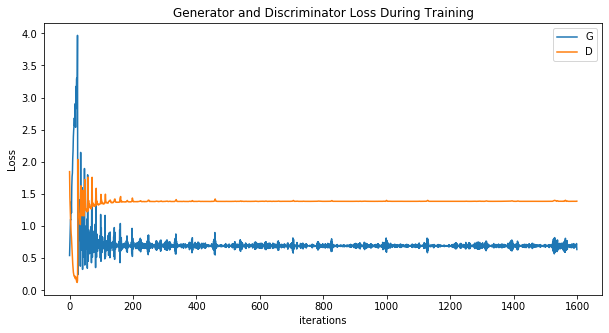

In [29]:
show_losses(G_losses, D_losses)

In [30]:
with torch.no_grad():
    fake_img = netG(real_batch[0].detach())

/Users/app/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


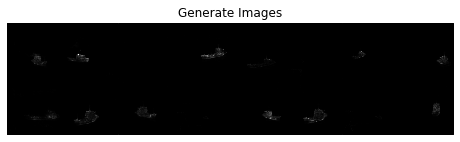

In [31]:
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Generate Images")
plt.imshow(np.transpose(vutils.make_grid(fake_img.to(device)[:batch_size], padding=2, normalize=True).cpu(),(1,2,0)))

In [32]:
import pickle

In [36]:
def save_losses(losses, file):
    with open(file, 'wb') as f:
        pickle.dump(losses, f)

In [37]:
def load_losses(file):
    with open(file, 'rb') as f:
        losses = pickle.load(f)
    return losses

In [38]:
save_losses(G_losses, '../losses/G_losses_epoch_50.pkl')
save_losses(D_losses, '../losses/D_losses_epoch_50.pkl')

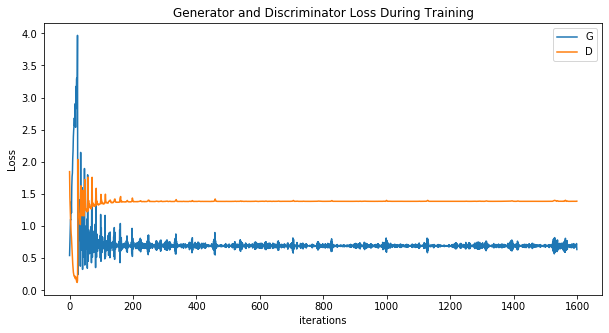

In [39]:
gl = load_losses('../losses/G_losses_epoch_50.pkl')
dl = load_losses('../losses/D_losses_epoch_50.pkl')
show_losses(gl, dl)